# Basic Mesh Composition and Plotting

We are about to build a compound mesh by transforming parts of a voxlized cylinder into tetrahedra and lines. Then we do some plotting and review the basics of configuring plots.

The following block shows a basic example with minimal API usage and common `NumPy` operations:

In [1]:
from sigmaepsilon.mesh.space import CartesianFrame
from sigmaepsilon.mesh.recipes import cylinder
from sigmaepsilon.mesh import PolyData, LineData
from sigmaepsilon.mesh.cells import H8, TET4
from sigmaepsilon.mesh.topo.tr import H8_to_L2, H8_to_TET4
from sigmaepsilon.mesh.topo import detach_mesh_bulk
from sigmaepsilon.math.array import minmax
import numpy as np

min_radius = 5
max_radius = 25
h = 50
angle = 1

shape = (min_radius, max_radius), angle, h
frame = CartesianFrame(dim=3)
cyl = cylinder(shape, size=5., voxelize=True, frame=frame)

coords = cyl.coords()
topo = cyl.topology()
centers = cyl.centers()

cxmin, cxmax = minmax(centers[:, 0])
czmin, czmax = minmax(centers[:, 2])
cxavg = (cxmin + cxmax)/2
czavg = (czmin + czmax)/2
b_upper = centers[:, 2] > czavg
b_lower = centers[:, 2] <= czavg
b_left = centers[:, 0] < cxavg
b_right = centers[:, 0] >= cxavg
iL2 = np.where(b_upper & b_right)[0]
iTET4 = np.where(b_upper & b_left)[0]
iH8 = np.where(b_lower)[0]
_, tL2 = H8_to_L2(coords, topo[iL2])
_, tTET4 = H8_to_TET4(coords, topo[iTET4])
tH8 = topo[iH8]


mesh = PolyData(coords=coords, frame=frame)
mesh['lines', 'L2'] = LineData(topo=tL2, frame=frame)
mesh['bodies', 'TET4'] = PolyData(topo=tTET4, celltype=TET4, frame=frame)

cH8, tH8 = detach_mesh_bulk(coords, tH8)
mesh['bodies', 'H8'] = PolyData(coords=cH8, topo=tH8, celltype=H8, frame=frame)


We can see for ourselves, that the mesh has a jagged topology:

In [2]:
bodies = mesh['bodies'].topology()
len(bodies[0]), len(bodies[-1])


(4, 8)

In [3]:
mesh['bodies'].volume()


71250.0

## Plotting with **PyVista**

Add some configuration to the `PyVista` plotting mechanism. This requires to think about
a ``config_key``, that later we can use to point at our configuration. The configurations
are stored in the ``config`` attribute of each block we are about to plot. For example,
to set some basic properties:

In [4]:
mesh['lines', 'L2'].config['pyvista', 'plot', 'color'] = 'red'
mesh['lines', 'L2'].config['pyvista', 'plot', 'line_width'] = 4

mesh['bodies', 'TET4'].config['pyvista', 'plot', 'show_edges'] = True
mesh['bodies', 'TET4'].config['pyvista', 'plot', 'color'] = 'yellow'
mesh['bodies', 'TET4'].config['pyvista', 'plot', 'opacity'] = 0.8

mesh['bodies', 'H8'].config['pyvista', 'plot', 'show_edges'] = True
mesh['bodies', 'H8'].config['pyvista', 'plot', 'color'] = 'cyan'
mesh['bodies', 'H8'].config['pyvista', 'plot', 'opacity'] = 1.0


The following block shows how to refer to the previously set config. 

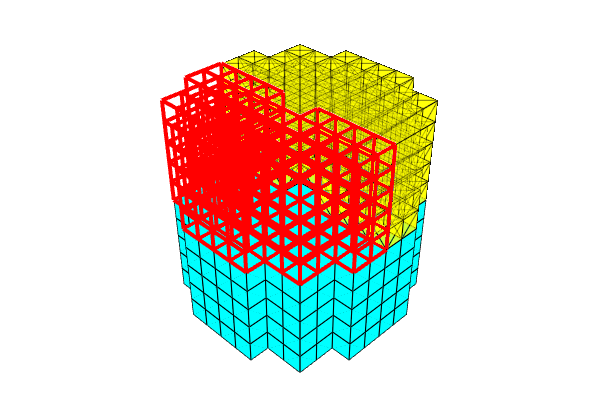

In [5]:
mesh.pvplot(notebook=True, jupyter_backend='static', cmap='plasma',
            window_size=(600, 400), config_key=('pyvista', 'plot'))


We can assign colors by setting numerical data on points or cells. All we have to do
is to provide the keyword argument ``scalars`` to `PyVista`. One way to do that is to
add these walues to the configuration of your block of choice. For example, to set random data on H8 hexagonals, do this:

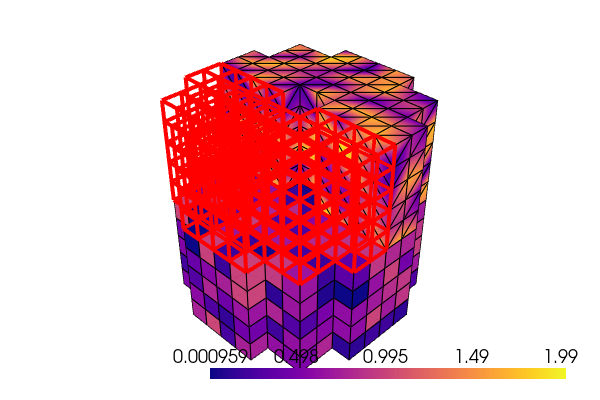

In [6]:
mesh['bodies', 'H8'].config['pyvista', 'plot',
                            'scalars'] = np.random.rand(tH8.shape[0])
ncTET4 = mesh['bodies', 'TET4'].coords(from_cells=True).shape[0]
mesh['bodies', 'TET4'].config['pyvista', 'plot',
                              'scalars'] = 2*np.random.rand(ncTET4)
mesh['bodies', 'TET4'].config['pyvista', 'plot', 'opacity'] = 1.0
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma')


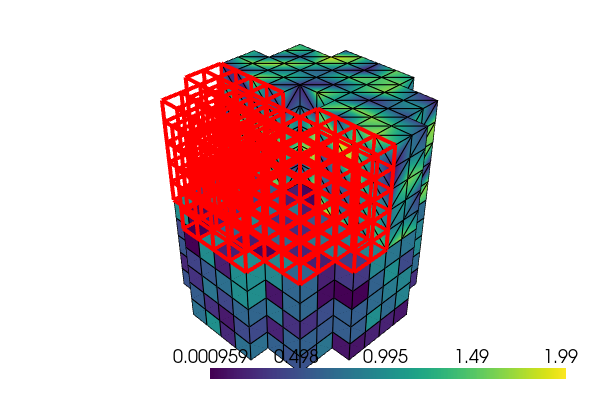

In [7]:
import pyvista as pv
plotter = pv.Plotter()
mesh.pvplot(plotter=plotter)
plotter.show(jupyter_backend='static', window_size=(600, 400))


### Background Plotting

This requires you to have `PyQt` and `pyvistaqt` installed, but it possible to plot
using a widget:

In [8]:
from pyvistaqt import BackgroundPlotter
plotter = BackgroundPlotter()
mesh.pvplot(plotter=plotter)
plotter.show()
